## 1. Description of the Problem
London is a popular destination for higher education where diverse students from all around the world gather to study.

According to the data published by the Higher Education Statistical Agency (HESA), in the academic year 2016-2017 London welcomed 112,200 international students to its higher education institutions, which make up 29 percent of students at higher education institutions.

One of the big concerns for international students when moving to a new city would be finding an accommodation. Student halls are the most reliable means of housing for students, but it is not easy to secure a place in one as they are in high demand. Therefore in this project, I intend to explore different neighborhoods of London and find the best area to build a new student hall for international students in London to solve this persistent problem and to find a new business opportunity.This research is expected to benefit real-estate investors looking for a profitable location or international students looking for a place to live in London.

From the student perspective, a lot of factors come into play when finding the best accommodation, including location and rent. Howerver, this study will focus only on the safety and the general atmosphere of the neighborhood. Distance to universities are also an important factor in choosing a student hall, but as student halls accept students from different universities, it will be disregarded in this project.

## 2. Data Acquisition and Preprocessing
In this project, I will be using the following datasets to help solve my problem - London Recorded Crime, List of London Boroughs, and Foursquare API.
Let's have a look at them.

### a. London Recorded Crime : Geographic Breakdown

London crime records by boroughs in the last 24 months
source: London Datastore
url: https://data.london.gov.uk/dataset/recorded_crime_summary

In [1]:
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_0686d600596c4bc6a16cbc7ba7d0bfcf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='PLeVJcn3hx6Vn3by7ULdERCui7aakrfuOFIUYJIQlPxP',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_0686d600596c4bc6a16cbc7ba7d0bfcf.get_object(Bucket='thebattleoftheneighborhoods-donotdelete-pr-vnx4j7hzok8o6r',Key='MPS Borough Level Crime (most recent 24 months).csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

crime = pd.read_csv(body)
crime.head()



,MajorText,MinorText,LookUp_BoroughName,201707,201708,201709,201710,201711,201712,201801,...,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2,5,8,7,7,4,2,...,3,8,5,1,5,2,5,5,11,3
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,143,169,134,132,108,119,135,...,107,131,105,88,97,127,137,130,139,108
2,Burglary,Burglary - Business and Community,Barking and Dagenham,42,30,25,23,27,21,38,...,33,32,39,33,44,24,29,27,22,27
3,Burglary,Burglary - Residential,Barking and Dagenham,95,83,81,122,88,124,143,...,99,94,106,164,114,107,99,96,114,96
4,Drug Offences,Drug Trafficking,Barking and Dagenham,7,1,6,7,5,6,4,...,9,6,7,2,5,1,6,4,8,6


In [2]:
# Dimension of Data
crime.shape

(1584, 27)

In [3]:
# Names of Boroughs
crime['LookUp_BoroughName'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'London Heathrow and London City Airports', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

In [4]:
# Create a column for sum of incidents in 24 months
crime['Sum'] = crime.iloc[:,3:27].sum(axis=1)
crimesum = crime['Sum']
crime.drop(labels=['Sum'], axis=1,inplace = True)
crime.insert(3, 'Sum', crimesum)
crime.head()

,MajorText,MinorText,LookUp_BoroughName,Sum,201707,201708,201709,201710,201711,201712,...,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
0,Arson and Criminal Damage,Arson,Barking and Dagenham,122,2,5,8,7,7,4,...,3,8,5,1,5,2,5,5,11,3
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,2934,143,169,134,132,108,119,...,107,131,105,88,97,127,137,130,139,108
2,Burglary,Burglary - Business and Community,Barking and Dagenham,728,42,30,25,23,27,21,...,33,32,39,33,44,24,29,27,22,27
3,Burglary,Burglary - Residential,Barking and Dagenham,2504,95,83,81,122,88,124,...,99,94,106,164,114,107,99,96,114,96
4,Drug Offences,Drug Trafficking,Barking and Dagenham,134,7,1,6,7,5,6,...,9,6,7,2,5,1,6,4,8,6


In [5]:
# Delete unnecessary columns
crime.drop(crime.columns[0:2], axis=1, inplace=True)
crime.drop(crime.columns[2:26], axis=1, inplace=True)
crime.head()

,LookUp_BoroughName,Sum
0,Barking and Dagenham,122
1,Barking and Dagenham,2934
2,Barking and Dagenham,728
3,Barking and Dagenham,2504
4,Barking and Dagenham,134


In [6]:
# Calculate sum of incidents in the last 24 months by boroughs
crime = crime.groupby(['LookUp_BoroughName'], as_index=False).sum()
crime.head()

,LookUp_BoroughName,Sum
0,Barking and Dagenham,37798
1,Barnet,57489
2,Bexley,31913
3,Brent,61295
4,Bromley,46531


In [7]:
# Change the sum into monthly average
crime['Sum'] = crime['Sum']/24
crime.rename(columns={crime.columns[1]:'MonthlyAverage'}, inplace=True)

crime.head()

,LookUp_BoroughName,MonthlyAverage
0,Barking and Dagenham,1574.916667
1,Barnet,2395.375000
2,Bexley,1329.708333
3,Brent,2553.958333
4,Bromley,1938.791667


In [8]:
# Explore the clean dataset - borough with most incidents?
crime.sort_values(by='MonthlyAverage', ascending=False).head()

,LookUp_BoroughName,MonthlyAverage
32,Westminster,5584.916667
5,Camden,3127.916667
27,Southwark,3040.375000
24,Newham,2989.250000
20,Lambeth,2951.625000


In [9]:
### Explore the clean dataset - borough with least incidents?
crime.sort_values(by='MonthlyAverage', ascending=True).head()

,LookUp_BoroughName,MonthlyAverage
22,London Heathrow and London City Airports,291.041667
19,Kingston upon Thames,1037.458333
28,Sutton,1038.333333
26,Richmond upon Thames,1078.208333
23,Merton,1157.916667


### b. List of London Boroughs

* Information on boroughs and their population & coordinates
-Population can be used to calcuate the ratio of reported crime to population for better comparison.
-Coordinates can be used to get neighborhood data from Foursquare.
* source: Wikipedia
* url: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [10]:
import requests
import lxml
from bs4 import BeautifulSoup

# Obtaining data from Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(source, 'lxml')
soup.encode("utf-8-sig")

b'\xef\xbb\xbf<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n<head>\n<meta charset="utf-8-sig"/>\n<title>List of London boroughs - Wikipedia</title>\n<script>document.documentElement.className=document.documentElement.className.replace(/(^|\\s)client-nojs(\\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":881899861,"wgRevisionId":881899861,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates","Geographic coordinate lists","Articles with Geo","London boroughs","Lists of places in London"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDate

In [11]:
BoroughName = []
Population = []
Coordinates = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 0:
        BoroughName.append(cells[0].text.rstrip('\n'))
        Population.append(cells[7].text.rstrip('\n'))
        Coordinates.append(cells[8].text.rstrip('\n'))

# Form a dataframe
dict = {'BoroughName' : BoroughName,
       'Population' : Population,
       'Coordinates': Coordinates}
info = pd.DataFrame.from_dict(dict)
info.head()

,BoroughName,Population,Coordinates
0,Barking and Dagenham [note 1],"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [12]:
# Strip unwanted texts
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(']'))
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip('1234567890.'))
info['BoroughName'] = info['BoroughName'].str.replace('note','')
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(' ['))
info.head()

,BoroughName,Population,Coordinates
0,Barking and Dagenham,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [13]:
# Clean coordinates
info[['Coordinates1','Coordinates2','Coordinates3']] = info['Coordinates'].str.split('/',expand=True)
info.head()

,BoroughName,Population,Coordinates,Coordinates1,Coordinates2,Coordinates3
0,Barking and Dagenham,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,51°33′39″N 0°09′21″E﻿,﻿51.5607°N 0.1557°E﻿,51.5607; 0.1557﻿ (Barking and Dagenham)
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,51°37′31″N 0°09′06″W﻿,﻿51.6252°N 0.1517°W﻿,51.6252; -0.1517﻿ (Barnet)
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,51°27′18″N 0°09′02″E﻿,﻿51.4549°N 0.1505°E﻿,51.4549; 0.1505﻿ (Bexley)
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,51°33′32″N 0°16′54″W﻿,﻿51.5588°N 0.2817°W﻿,51.5588; -0.2817﻿ (Brent)
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...,51°24′14″N 0°01′11″E﻿,﻿51.4039°N 0.0198°E﻿,51.4039; 0.0198﻿ (Bromley)


In [14]:
info.drop(labels=['Coordinates','Coordinates1','Coordinates2'], axis=1,inplace = True)
info[['Latitude','Longitude']] = info['Coordinates3'].str.split(';',expand=True)
info.head()

,BoroughName,Population,Coordinates3,Latitude,Longitude
0,Barking and Dagenham,"194,352",51.5607; 0.1557﻿ (Barking and Dagenham),51.5607,0.1557﻿ (Barking and Dagenham)
1,Barnet,"369,088",51.6252; -0.1517﻿ (Barnet),51.6252,-0.1517﻿ (Barnet)
2,Bexley,"236,687",51.4549; 0.1505﻿ (Bexley),51.4549,0.1505﻿ (Bexley)
3,Brent,"317,264",51.5588; -0.2817﻿ (Brent),51.5588,-0.2817﻿ (Brent)
4,Bromley,"317,899",51.4039; 0.0198﻿ (Bromley),51.4039,0.0198﻿ (Bromley)


In [15]:
info.drop(labels=['Coordinates3'], axis=1,inplace = True)
info['Latitude'] = info['Latitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Latitude'] = info['Latitude'].map(lambda x: x.lstrip())
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(')'))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(' ('))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Longitude'] = info['Longitude'].map(lambda x: x.lstrip())
info['Population'] = info['Population'].str.replace(',','')
info.head()

,BoroughName,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


In [16]:
info['BoroughName'].unique()


array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

### c. Foursquare API

* List of top 50 popular places in the neighborhood
* source: Foursquare
* url: https://api.foursquare.com

In [17]:
# Foursquare credentials
CLIENT_ID = 'S3ONPSOKENADL51USBUU4BATDOAQZUZ0WJL13VCXOPDXKQ33' # Foursquare ID
CLIENT_SECRET = '4HGT1KWEEAAPJYSWGNN0IGBOYHVVOMA01AAIH5Q5QSJXHH4T' # Foursquare Secret
VERSION = '20181206' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S3ONPSOKENADL51USBUU4BATDOAQZUZ0WJL13VCXOPDXKQ33
CLIENT_SECRET:4HGT1KWEEAAPJYSWGNN0IGBOYHVVOMA01AAIH5Q5QSJXHH4T


In [18]:
#Create a function to explore all borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BoroughName', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#Get top 50 venues in 500m radius of the center of each Borough
LIMIT = 50
venues = getNearbyVenues(names=info['BoroughName'],
                                   latitudes=info['Latitude'],
                                   longitudes=info['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [19]:
print(venues.shape)
venues.head()

(1128, 7)


,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center
2,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
3,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts Dojo
4,Barking and Dagenham,51.5607,0.1557,Morrisons Becontree Heath,51.559774,0.148752,Supermarket


## 3. Methodology

In this section, we will explore the cleansed data more thoroughly using visualizations. Then, we will conduct cluster analysis to classify the boroughs into different levels of preference.

### a. Exploratory Analysis

In [20]:
#Review our data
crime.head()


,LookUp_BoroughName,MonthlyAverage
0,Barking and Dagenham,1574.916667
1,Barnet,2395.375000
2,Bexley,1329.708333
3,Brent,2553.958333
4,Bromley,1938.791667


In [21]:
info.head()


,BoroughName,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


In [22]:
venues.head()


,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center
2,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
3,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts Dojo
4,Barking and Dagenham,51.5607,0.1557,Morrisons Becontree Heath,51.559774,0.148752,Supermarket


In [23]:
import matplotlib.pyplot as plt

#Visualize crime data
crime.set_index('LookUp_BoroughName')['MonthlyAverage'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Monthly Average of Crime Incidents')
plt.title('Monthly Crime Incidents in London')
plt.show()

<Figure size 1000x1000 with 1 Axes>

Westminster has the biggest number of reported crime, followed by Camden, Southwark and Newham.



In [24]:
#Drop Heathrow Airport as it is not a residential area & not included in population data
crime.drop([22], inplace=True)



In [25]:
#Combine crime data and borough information data
df = pd.merge(crime, info, left_on='LookUp_BoroughName', right_on='BoroughName')
df = df.drop(['LookUp_BoroughName'], axis=1)
df.head()

,MonthlyAverage,BoroughName,Population,Latitude,Longitude
0,1574.916667,Barking and Dagenham,194352,51.5607,0.1557
1,2395.375000,Barnet,369088,51.6252,-0.1517
2,1329.708333,Bexley,236687,51.4549,0.1505
3,2553.958333,Brent,317264,51.5588,-0.2817
4,1938.791667,Bromley,317899,51.4039,0.0198


In [26]:
#Check data type
df.dtypes

MonthlyAverage    float64
BoroughName        object
Population         object
Latitude           object
Longitude          object
dtype: object

In [27]:
df['Population'] = pd.to_numeric(df['Population'])
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])
df.dtypes

MonthlyAverage    float64
BoroughName        object
Population          int64
Latitude          float64
Longitude         float64
dtype: object

In [28]:
df.shape


(32, 5)

In [29]:
#Create a column that shows the number of crimes per 1000 people per month
df['Population'].astype('float')
df['CrimeToPop'] = (df['MonthlyAverage'] / df['Population']) * 1000
df.head()

,MonthlyAverage,BoroughName,Population,Latitude,Longitude,CrimeToPop
0,1574.916667,Barking and Dagenham,194352,51.5607,0.1557,8.103424
1,2395.375000,Barnet,369088,51.6252,-0.1517,6.489983
2,1329.708333,Bexley,236687,51.4549,0.1505,5.618003
3,2553.958333,Brent,317264,51.5588,-0.2817,8.049947
4,1938.791667,Bromley,317899,51.4039,0.0198,6.098766


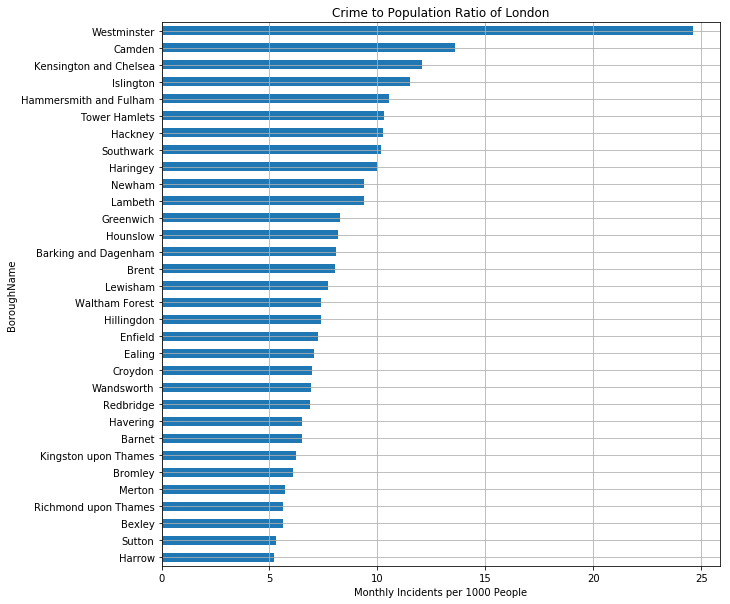

In [30]:
#Visualize crime per 1000 people
df.set_index('BoroughName')['CrimeToPop'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Monthly Incidents per 1000 People')
plt.title('Crime to Population Ratio of London')
plt.show()

In [31]:
!pip install folium
import folium
from geopy.geocoders import Nominatim

#Get coordinates of London
address = 'London, UK'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

     |████████████████████████████████| 92kB 1.7MB/s eta 0:00:01
The geograpical coordinate of Toronto are 51.4893335, -0.144055084527687.


In [32]:
# make a map of London using folium
map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['BoroughName']):
    label = '{}'.format(borough)
    label2 = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

We can see that Westminster and Camden still remains top 2 dangerous area even after taking population into consideration.

### b. Cluster Analysis
In this part, we will conduct K-means clustering to group the boroughs according to what convenience facilities they have using Foursquare data

In [33]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))


There are 182 uniques categories.


In [34]:
# One hot encoding before clustering
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# Add borough name back to dataframe
borough = venues['BoroughName']
onehot.insert(0, 'BoroughName', borough)
onehot.head()

,BoroughName,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
onehot.shape


(1128, 183)

In [36]:
# Group rows by borough and take the mean of frequency of each venue category
grouped = onehot.groupby('BoroughName').mean().reset_index()
grouped

,BoroughName,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00
1,Barnet,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00
2,Bexley,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,...,0.00,0.000000,0.038462,0.00,0.038462,0.00,0.00,0.00,0.000000,0.00
3,Brent,0.000,0.000000,0.000000,0.000000,0.04,0.00,0.000000,0.00,0.020000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00
4,Bromley,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.025000,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.025000,0.00
5,Camden,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,...,0.02,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00
6,Croydon,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.054054,...,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00
7,Ealing,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.020000,0.00,0.020000,...,0.00,0.000000,0.020000,0.04,0.000000,0.02,0.00,0.00,0.000000,0.00
8,Enfield,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,...,0.04,0.000000,0.040000,0.00,0.000000,0.00,0.00,0.00,0.040000,0.00
9,Greenwich,0.025,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.025000,...,0.00,0.000000,0.000000,0.00,0.025000,0.00,0.00,0.00,0.000000,0.00


In [37]:
# top 5 venues for each neighborhood
num_top_venues = 5

for hood in grouped['BoroughName']:
    print("----"+hood+"----")
    temp = grouped[grouped['BoroughName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
         venue  freq
0  Bus Station  0.14
1         Park  0.14
2         Pool  0.14
3  Supermarket  0.14
4  Golf Course  0.14


----Barnet----
                   venue  freq
0                   Café  0.67
1               Bus Stop  0.33
2     African Restaurant  0.00
3  Performing Arts Venue  0.00
4        Organic Grocery  0.00


----Bexley----
                venue  freq
0                 Pub  0.12
1         Coffee Shop  0.12
2  Italian Restaurant  0.08
3         Supermarket  0.08
4      Clothing Store  0.08


----Brent----
                 venue  freq
0          Coffee Shop  0.10
1                Hotel  0.10
2       Clothing Store  0.08
3  Sporting Goods Shop  0.06
4                  Bar  0.04


----Bromley----
                  venue  freq
0           Coffee Shop  0.15
1        Clothing Store  0.12
2  Gym / Fitness Center  0.05
3          Burger Joint  0.05
4                   Bar  0.05


----Camden----
            venue  freq
0           Hotel  0.10
1   

In [38]:
# Put into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BoroughName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['BoroughName'] = grouped['BoroughName']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Martial Arts Dojo,Pool,Bus Station,Supermarket,Park,Gym / Fitness Center,Golf Course,Yoga Studio,Flea Market,Fish Market
1,Barnet,Café,Bus Stop,Yoga Studio,Farmers Market,French Restaurant,Food Court,Food,Flea Market,Fish Market,Fish & Chips Shop
2,Bexley,Coffee Shop,Pub,Italian Restaurant,Supermarket,Fast Food Restaurant,Clothing Store,Hotel,Grocery Store,Furniture / Home Store,Multiplex
3,Brent,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Bar,Grocery Store,Sandwich Place,Italian Restaurant,American Restaurant,Café
4,Bromley,Coffee Shop,Clothing Store,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Noodle House,Stationery Store,Burrito Place,Café


In [39]:
# K Means Clustering
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

kclusters = 5
london_cluster = grouped.drop('BoroughName', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_cluster)

kmeans.labels_[0:10]

array([4, 2, 3, 0, 3, 0, 3, 3, 3, 3], dtype=int32)

In [40]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto coords to add latitude/longitude for each neighborhood
london_merged = df
london_merged = london_merged.join(venues_sorted.set_index('BoroughName'), on='BoroughName')

london_merged.head()

,MonthlyAverage,BoroughName,Population,Latitude,Longitude,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1574.916667,Barking and Dagenham,194352,51.5607,0.1557,8.103424,4,Martial Arts Dojo,Pool,Bus Station,Supermarket,Park,Gym / Fitness Center,Golf Course,Yoga Studio,Flea Market,Fish Market
1,2395.375000,Barnet,369088,51.6252,-0.1517,6.489983,2,Café,Bus Stop,Yoga Studio,Farmers Market,French Restaurant,Food Court,Food,Flea Market,Fish Market,Fish & Chips Shop
2,1329.708333,Bexley,236687,51.4549,0.1505,5.618003,3,Coffee Shop,Pub,Italian Restaurant,Supermarket,Fast Food Restaurant,Clothing Store,Hotel,Grocery Store,Furniture / Home Store,Multiplex
3,2553.958333,Brent,317264,51.5588,-0.2817,8.049947,0,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Bar,Grocery Store,Sandwich Place,Italian Restaurant,American Restaurant,Café
4,1938.791667,Bromley,317899,51.4039,0.0198,6.098766,3,Coffee Shop,Clothing Store,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Noodle House,Stationery Store,Burrito Place,Café


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let's observe each clusters and name them according to their characteristics



In [42]:
# Cluster 0: Traveller area
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,MonthlyAverage,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,2553.958333,8.049947,0,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Bar,Grocery Store,Sandwich Place,Italian Restaurant,American Restaurant,Café
5,3127.916667,13.616273,0,Hotel,Coffee Shop,Café,Train Station,Hotel Bar,Pizza Place,Breakfast Spot,Bookstore,Plaza,Turkish Restaurant
13,1266.500000,5.203968,0,Coffee Shop,Indie Movie Theater,Indian Restaurant,Convenience Store,Platform,Supermarket,Exhibit,Food,Flea Market,Fish Market
23,2989.250000,9.393452,0,Hotel,Airport,Airport Lounge,Airport Service,Chinese Restaurant,Pharmacy,Sandwich Place,Rafting,Coffee Shop,Fast Food Restaurant
28,2810.458333,10.298869,0,Italian Restaurant,Hotel,Coffee Shop,Café,Gym / Fitness Center,Grocery Store,Outdoor Sculpture,Pizza Place,Restaurant,Chinese Restaurant
31,5584.916667,24.620402,0,Hotel,Sandwich Place,Coffee Shop,Theater,Sushi Restaurant,Hotel Bar,Juice Bar,Fast Food Restaurant,Salad Place,Café


In [43]:
# Cluster 1: Lively area 
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,MonthlyAverage,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,2147.958333,8.185598,1,Bed & Breakfast,Pizza Place,Café,Park,Yoga Studio,Falafel Restaurant,Food Court,Food,Flea Market,Fish Market


In [44]:
# Cluster 2: Quiet Area
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,MonthlyAverage,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2395.375,6.489983,2,Café,Bus Stop,Yoga Studio,Farmers Market,French Restaurant,Food Court,Food,Flea Market,Fish Market,Fish & Chips Shop


In [45]:
# Cluster 3: Busy area
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,MonthlyAverage,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,1329.708333,5.618003,3,Coffee Shop,Pub,Italian Restaurant,Supermarket,Fast Food Restaurant,Clothing Store,Hotel,Grocery Store,Furniture / Home Store,Multiplex
4,1938.791667,6.098766,3,Coffee Shop,Clothing Store,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Noodle House,Stationery Store,Burrito Place,Café
6,2604.333333,6.986772,3,Coffee Shop,Pub,Asian Restaurant,Gym / Fitness Center,Spanish Restaurant,Malay Restaurant,Bookstore,Clothing Store,Gaming Cafe,Breakfast Spot
7,2425.333333,7.081389,3,Coffee Shop,Italian Restaurant,Burger Joint,Park,Bar,Bakery,Pizza Place,Vietnamese Restaurant,Pub,Hotel
8,2322.166667,7.244907,3,Coffee Shop,Sandwich Place,Clothing Store,Pub,Bookstore,Supermarket,Mobile Phone Shop,Café,Restaurant,Women's Store
9,2185.250000,8.277211,3,Coffee Shop,Fast Food Restaurant,Sandwich Place,Pub,Hotel,Supermarket,Grocery Store,Clothing Store,Plaza,Breakfast Spot
10,2645.291667,10.277807,3,Pub,Coffee Shop,Cocktail Bar,Café,Brewery,Hotel,Clothing Store,Grocery Store,Scandinavian Restaurant,Sandwich Place
11,1882.916667,10.537631,3,Pub,Italian Restaurant,Indian Restaurant,Café,Japanese Restaurant,Gastropub,Clothing Store,Video Game Store,Park,Restaurant
12,2625.208333,9.967152,3,Fast Food Restaurant,Italian Restaurant,Supermarket,Hotel Bar,Gym / Fitness Center,Grocery Store,Mediterranean Restaurant,Movie Theater,Food,Park
14,1573.791667,6.501122,3,Clothing Store,Coffee Shop,Shopping Mall,Bakery,Fast Food Restaurant,Café,Bookstore,Hotel,Warehouse Store,Plaza


In [46]:
# Cluster 4: Healthy area
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,MonthlyAverage,CrimeToPop,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1574.916667,8.103424,4,Martial Arts Dojo,Pool,Bus Station,Supermarket,Park,Gym / Fitness Center,Golf Course,Yoga Studio,Flea Market,Fish Market


## 4. Results & Recommendation
Now we will review all the analysis made in this project before we make a conclusion on which area to live as an international student or invest as a student accommodation builder.

Like mentioned in the beginning, our key criteria of location decision will be based on safety and atmosphere.

### a. Safety
Safety can be determined by the criminal rate we have calculated. We can use the 'CrimeToPop' (Recorded crime per 1000 people) as our safety score.

In [47]:
crimetopop = london_merged['CrimeToPop']
london_merged.drop(['CrimeToPop'], inplace=True, axis=1)
london_merged.insert(1, 'CrimeToPop', crimetopop)
london_merged.sort_values(by='CrimeToPop', ascending = False)

,MonthlyAverage,CrimeToPop,BoroughName,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,5584.916667,24.620402,Westminster,226841,51.4973,-0.1372,0,Hotel,Sandwich Place,Coffee Shop,Theater,Sushi Restaurant,Hotel Bar,Juice Bar,Fast Food Restaurant,Salad Place,Café
5,3127.916667,13.616273,Camden,229719,51.5290,-0.1255,0,Hotel,Coffee Shop,Café,Train Station,Hotel Bar,Pizza Place,Breakfast Spot,Bookstore,Plaza,Turkish Restaurant
18,1874.875000,12.049790,Kensington and Chelsea,155594,51.5020,-0.1947,3,Clothing Store,English Restaurant,Garden,Restaurant,Gym / Fitness Center,Burger Joint,Café,French Restaurant,Juice Bar,Bakery
17,2482.250000,11.509642,Islington,215667,51.5416,-0.1022,3,Pub,Cocktail Bar,Bakery,Mediterranean Restaurant,Turkish Restaurant,Music Venue,Furniture / Home Store,Theater,Middle Eastern Restaurant,Boutique
11,1882.916667,10.537631,Hammersmith and Fulham,178685,51.4927,-0.2339,3,Pub,Italian Restaurant,Indian Restaurant,Café,Japanese Restaurant,Gastropub,Clothing Store,Video Game Store,Park,Restaurant
28,2810.458333,10.298869,Tower Hamlets,272890,51.5099,-0.0059,0,Italian Restaurant,Hotel,Coffee Shop,Café,Gym / Fitness Center,Grocery Store,Outdoor Sculpture,Pizza Place,Restaurant,Chinese Restaurant
10,2645.291667,10.277807,Hackney,257379,51.5450,-0.0553,3,Pub,Coffee Shop,Cocktail Bar,Café,Brewery,Hotel,Clothing Store,Grocery Store,Scandinavian Restaurant,Sandwich Place
26,3040.375000,10.186739,Southwark,298464,51.5035,-0.0804,3,Pub,Hotel,Coffee Shop,Bar,Pizza Place,Thai Restaurant,Theater,English Restaurant,Art Gallery,Hotel Bar
12,2625.208333,9.967152,Haringey,263386,51.6000,-0.1119,3,Fast Food Restaurant,Italian Restaurant,Supermarket,Hotel Bar,Gym / Fitness Center,Grocery Store,Mediterranean Restaurant,Movie Theater,Food,Park
23,2989.250000,9.393452,Newham,318227,51.5077,0.0469,0,Hotel,Airport,Airport Lounge,Airport Service,Chinese Restaurant,Pharmacy,Sandwich Place,Rafting,Coffee Shop,Fast Food Restaurant


### b. Atmosphere
And from the cluster analysis made above, we will give each clusters a name according to the characteristics inferrable from the popular venues.

According to my interpretation, Cluster 0 is 'Healthy Area' with gyms, parks, pools and golf courses as popular places.

In [48]:
london_merged.loc[london_merged['Cluster Labels'] == 0].BoroughName.unique()


array(['Brent', 'Camden', 'Harrow', 'Newham', 'Tower Hamlets',
       'Westminster'], dtype=object)

According to my interpretation, Cluster 1 is 'Lively Area' with many pubs and restaurants.



In [49]:
london_merged.loc[london_merged['Cluster Labels'] == 1].BoroughName.unique()


array(['Hounslow'], dtype=object)

According to my interpretation, Cluster 2 is 'Busy Area' with many coffee shops and clothing stores.



In [50]:
london_merged.loc[london_merged['Cluster Labels'] == 2].BoroughName.unique()


array(['Barnet'], dtype=object)

According to my interpretation, Cluster 3 is 'Quiet Area' with cafe, bus stop, and yoga studio as top venues.



In [51]:
london_merged.loc[london_merged['Cluster Labels'] == 3].BoroughName.unique()


array(['Bexley', 'Bromley', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Havering',
       'Hillingdon', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Waltham Forest', 'Wandsworth'], dtype=object)

According to my interpretation, Cluster 4 is 'Traveller Area' with bed & breakfast, hotels, and airport.



In [52]:
london_merged.loc[london_merged['Cluster Labels'] == 4].BoroughName.unique()


array(['Barking and Dagenham'], dtype=object)

Now, what kind of atmosphere students may prefer differ by every student. So using my personal preferance as a student moving to London and some common sense, I will give scores to each clusters.
I have decided to give preference in the order of Busy Area, Lively Area, Healthy Area, Quiet Area, and Traveller Area.

### c. Weighted score table
Finally, let's calculate the scores of each borough.

In [53]:
score = london_merged[['BoroughName','CrimeToPop','Cluster Labels']].copy()
score.head()

,BoroughName,CrimeToPop,Cluster Labels
0,Barking and Dagenham,8.103424,4
1,Barnet,6.489983,2
2,Bexley,5.618003,3
3,Brent,8.049947,0
4,Bromley,6.098766,3


In [54]:
score['Safety'] = (score['CrimeToPop']-score['CrimeToPop'].min())/(score['CrimeToPop'].max()-score['CrimeToPop'].min())
score['Safety'] = (score['Safety'] - 1) * -1
score.head()

,BoroughName,CrimeToPop,Cluster Labels,Safety
0,Barking and Dagenham,8.103424,4,0.850670
1,Barnet,6.489983,2,0.933767
2,Bexley,5.618003,3,0.978676
3,Brent,8.049947,0,0.853424
4,Bromley,6.098766,3,0.953915


In [55]:
score['Atmosphere'] = 0
score.head()

,BoroughName,CrimeToPop,Cluster Labels,Safety,Atmosphere
0,Barking and Dagenham,8.103424,4,0.850670,0
1,Barnet,6.489983,2,0.933767,0
2,Bexley,5.618003,3,0.978676,0
3,Brent,8.049947,0,0.853424,0
4,Bromley,6.098766,3,0.953915,0


In [56]:
for i in range(32):
    if score.iloc[i,2] == 2:
        score.iloc[i,4] = 1
    elif score.iloc[i,2] == 1:
        score.iloc[i,4] = 0.9
    elif score.iloc[i,2] == 0:
        score.iloc[i,2] = 0.8
    elif score.iloc[i,2] == 3:
        score.iloc[i,4] = 0.7
    else:
        score.iloc[i,2] = 0.6
                
score.head()

,BoroughName,CrimeToPop,Cluster Labels,Safety,Atmosphere
0,Barking and Dagenham,8.103424,0.6,0.850670,0.0
1,Barnet,6.489983,2.0,0.933767,1.0
2,Bexley,5.618003,3.0,0.978676,0.7
3,Brent,8.049947,0.8,0.853424,0.0
4,Bromley,6.098766,3.0,0.953915,0.7


In [57]:
score.drop(['CrimeToPop'], inplace=True, axis=1)
score.drop(['Cluster Labels'], inplace=True, axis=1)
score['Score'] = score['Safety'] + score['Atmosphere']
score.sort_values(by='Score', ascending = False)

,BoroughName,Safety,Atmosphere,Score
1,Barnet,0.933767,1.0,1.933767
16,Hounslow,0.846438,0.9,1.746438
27,Sutton,0.995057,0.7,1.695057
2,Bexley,0.978676,0.7,1.678676
25,Richmond upon Thames,0.977837,0.7,1.677837
22,Merton,0.974568,0.7,1.674568
4,Bromley,0.953915,0.7,1.653915
19,Kingston upon Thames,0.947670,0.7,1.647670
14,Havering,0.933193,0.7,1.633193
24,Redbridge,0.913862,0.7,1.613862


### 5. Conclusion
From our analysis, we have found that the five boroughs below are the best places to build a student hall, based on safety and atmosphere of the neighborhood. The top five boroughs all belong to the Busy Area cluster, with many coffee shops and clothing stores. Therefore, what differentiates them is the safety score, which was calculated from monthly recorded crimes per 1000 people.

In [58]:
df_top5 = df.iloc[[1,16,27,2,25],:]
df_top5

,MonthlyAverage,BoroughName,Population,Latitude,Longitude,CrimeToPop
1,2395.375000,Barnet,369088,51.6252,-0.1517,6.489983
16,2147.958333,Hounslow,262407,51.4746,-0.3680,8.185598
27,1038.333333,Sutton,195914,51.3618,-0.1945,5.299945
2,1329.708333,Bexley,236687,51.4549,0.1505,5.618003
25,1078.208333,Richmond upon Thames,191365,51.4479,-0.3260,5.634303


In [59]:
# make a map of Toronto using folium
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_top5['Latitude'], df_top5['Longitude'], df_top5['BoroughName']):
    label = '{}'.format(borough)
    label2 = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

## Limitations
However, it obviously seems strange that the best places to live in Loondon are all far out suburbs. This is due to limitations this research holds. Among numerous factors that determine a good neighborhood, we only took into consideration what type of venues are popular and how many crime incidents are recorded for the sake of simplification. This means that serious crimes like homicide was treated the same as a comparatively petty crime like shoplifting. Moreover, the number of stores in the neighborhood may be as important as what type of stores there are.

To overcome the limitations of this study, we will need further data such as distance to city center and housing prices. Also, taking crime categories into factor and weighting them differently may be helpful. Nevertheless, this research was still meaningful in that we were able to explore the neighborhoods in depth.